In [1]:
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [34]:
spacy.load("en_core_web_sm")


In [36]:
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz


  Using cached blis-0.4.1-cp36-cp36m-win_amd64.whl (5.0 MB)
  Using cached catalogue-1.0.0-py2.py3-none-any.whl (7.7 kB)
  Using cached srsly-1.0.2-cp36-cp36m-win_amd64.whl (179 kB)
  Using cached preshed-3.0.2-cp36-cp36m-win_amd64.whl (105 kB)
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019132 sha256=ec975c79660409cc3d862928efb35cd59a827974145d1fdcc9a7d6c64903b64d
  Stored in directory: c:\users\gupta\appdata\local\pip\cache\wheels\1d\bc\94\171b09b7fcce517723f40606754e5b7374770cc39290e092bf
Successfully built en-core-web-sm
  Attempting uninstall: blis
    Found existing installation: blis 0.2.4
    Uninstalling blis-0.2.4:
      Successfully uninstalled blis-0.2.4


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\gupta\\anaconda3\\lib\\site-packages\\~lis\\cy.cp36-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [12]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

C:\Users\gupta\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
import seaborn as sns

In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

In [14]:
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",7,rec.autos
1,"From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 11\nNNTP-Posting-Host: carson.u.washington.edu\n\nA fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.\n\nGuy Kuo <guykuo@u.washington.edu>\n",4,comp.sys.mac.hardware
2,"From: twillis@ec.ecn.purdue.edu (Thomas E Willis)\nSubject: PB questions...\nOrganization: Purdue University Engineering Computer Network\nDistribution: usa\nLines: 36\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd heard the 185c was supposed to make an\nappearence ""this summer"" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180? i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much ""better"" the display is (yea, it looks great in the\nstore, but is that all ""wow"" or is it really that good?). could i solicit\nsome opinions of people who use the 160 and 180 day-to-day on if its worth\ntaking the disk size and money hit to get the active display? (i realize\nthis is a real subjective question, but i've only played around with the\nmachines in a computer store breifly and figured the opinions of somebody\nwho actually uses the machine daily might prove helpful).\n\n* how well does hellcats perform? ;)\n\nthanks a bunch in advance for any info - if you could email, i'll post a\nsummary (news reading time is at a premium with finals just around the\ncorner... :( )\n--\nTom Willis \ twillis@ecn.purdue.edu \ Purdue Electrical Engineering\n---------------------------------------------------------------------------\n""Convictions are more dangerous enemies of truth than lies."" - F. W.\nNietzsche\n",4,comp.sys.mac.hardware
3,"From: jgreen@amber (Joe Green)\nSubject: Re: Weitek P9000 ?\nOrganization: Harris Computer Systems Division\nLines: 14\nDistribution: world\nNNTP-Posting-Host: amber.ssd.csd.harris.com\nX-Newsreader: TIN [version 1.1 PL9]\n\nRobert J.C. Kyanko (rob@rjck.UUCP)

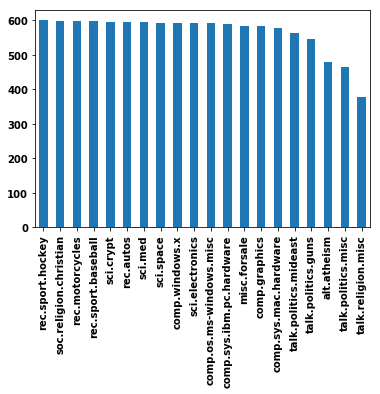

In [18]:
df.target_names.value_counts().plot(kind='bar')

In [27]:
df.content.iloc[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [23]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [28]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [29]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [30]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [39]:
#call above functions
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [40]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)]]


In [41]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('specs', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

In [42]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [43]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.141*"team" + 0.140*"game" + 0.081*"play" + 0.080*"sale" + 0.033*"nhl" + '
  '0.029*"trade" + 0.029*"cd" + 0.018*"ice" + 0.014*"detroit" + 0.014*"joe"'),
 (1,
  '0.086*"pin" + 0.044*"processor" + 0.044*"character" + 0.040*"font" + '
  '0.034*"mirror" + 0.018*"radius" + 0.018*"quran" + 0.017*"stephen" + '
  '0.014*"ford" + 0.012*"alot"'),
 (2,
  '0.048*"notice" + 0.040*"material" + 0.037*"signal" + 0.037*"external" + '
  '0.030*"circuit" + 0.022*"case_western" + 0.022*"reserve_university" + '
  '0.021*"oil" + 0.018*"charle" + 0.016*"william"'),
 (3,
  '0.054*"not" + 0.034*"do" + 0.028*"would" + 0.026*"be" + 0.021*"say" + '
  '0.020*"think" + 0.019*"know" + 0.017*"go" + 0.016*"people" + 0.015*"get"'),
 (4,
  '0.084*"library" + 0.061*"object" + 0.045*"cub" + 0.011*"static" + '
  '0.008*"compiler" + 0.008*"void" + 0.006*"borland" + 0.006*"bc" + '
  '0.003*"sps" + 0.001*"initialize"'),
 (5,
  '0.112*"israel" + 0.061*"israeli" + 0.045*"jew" + 0.038*"arab" + '
  '0.037*"jewish" + 0.0

In [44]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.150704038153219

Coherence Score:  0.4993186780826996


In [45]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.333024  0.156890  1       1        25.845465
14     0.319859  0.055759  2       1        19.784018
17     0.243947 -0.014504  3       1        13.459000
9      0.198548 -0.182722  4       1        7.392797 
16     0.150128  0.177248  5       1        6.862653 
13     0.189958 -0.208622  6       1        5.726238 
10     0.211524  0.155545  7       1        5.408626 
7     -0.055170 -0.000534  8       1        4.377950 
6      0.050057 -0.261877  9       1        3.286464 
18    -0.001138 -0.087063  10      1        2.102192 
19    -0.091274 -0.029054  11      1        0.939599 
0     -0.131892  0.024653  12      1        0.904270 
5     -0.131713  0.054581  13      1        0.748004 
8     -0.162082  0.021789  14      1        0.709176 
15    -0.166527  0.023128  15      1        0.695952 
2     -0.173124  0.023528  16      1        0.548464 
11    -0.176984  0.021626  17      1        0.540937 
12    -0.197899  0.022877  18      1        0.262125 
1     -0.196494  0.023311  19      1        0.254505 
4     -0.212748  0.023442  20      1        0.151570 , topic_info=               Term          Freq         Total Category  logprob  loglift
5531   ax            53197.000000  53197.000000  Default  30.0000  30.0000
21     line          18768.000000  18768.000000  Default  29.0000  29.0000
30     organization  17220.000000  17220.000000  Default  28.0000  28.0000
80     not           22213.000000  22213.000000  Default  27.0000  27.0000
238    write         14309.000000  14309.000000  Default  26.0000  26.0000
...      ...                  ...           ...      ...      ...      ...
25150  sqs           0.025980      1.281658      Topic20 -11.4342  2.5933 
26503  ucs           0.025980      1.281660      Topic20 -11.4342  2.5933 
5742   rlk           0.025982      1.281762      Topic20 -11.4342  2.5933 
25138  shz           0.025979      1.281656      Topic20 -11.4342  2.5933 
8177   sj            0.025980      1.281691      Topic20 -11.4342  2.5933 

[883 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
49    15     0.960435  acceleration
1630  1      0.292942  accept      
1630  7      0.681166  accept      
1630  13     0.024327  accept      
101   4      0.053286  access      
...   ..          ...     ...      
4492  8      0.983481  xview       
2381  16     0.982140  yankee      
48    2      0.999814  year        
2766  12     0.954231  ysebaert    
2675  15     0.996617  zone        

[1143 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 15, 18, 10, 17, 14, 11, 8, 7, 19, 20, 1, 6, 9, 16, 3, 12, 13, 2, 5])